In [2]:
import numpy as np
import igraph as ig
import scipy
from src import renormalizable_model, network_properties
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

In [3]:
weighted_adj_matrix = np.loadtxt(open("data/fg_empiricalNTW(node_num=1000).csv", "rb"), delimiter=",").reshape((1000,1000))

In [4]:
strength_data = np.loadtxt(open("data/fg_strengths(node_num=1000).csv", "rb"), delimiter=",")

In [5]:
sampled_out_strengths, sampled_in_strengths, ext_equities = strength_data

In [6]:
out_strengths = np.sum(weighted_adj_matrix, axis=1)
in_strengths = np.sum(weighted_adj_matrix, axis=0)
equities = np.array([np.sum(weighted_adj_matrix[i,:]) - np.sum(weighted_adj_matrix[:,i]) + ext_equities[i] for i in range(len(weighted_adj_matrix))])
leverage_matrix = weighted_adj_matrix/equities[:,None]

In [7]:
empirical_max_eigenvalue = np.max(np.abs(np.linalg.eigvals(leverage_matrix)))
print("Max eigenvalue of empirical network:", empirical_max_eigenvalue)

Max eigenvalue of empirical network: 0.05555555564559029


In [8]:
synthetic_graph = ig.Graph.Weighted_Adjacency(weighted_adj_matrix)

## Synthetic network properties

#### Isolated nodes

In [9]:
degrees = synthetic_graph.degree()

In [10]:
print("Number of isolated nodes is", degrees.count(0))

Number of isolated nodes is 0


#### ANND

In [11]:
original_annd_out, original_annd_k_out = network_properties.annd(synthetic_graph, mode="out")

/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist


Ensemble

In [12]:
num_of_links = np.sum(weighted_adj_matrix > 0)

In [13]:
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [15]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.019080723824060897


In [16]:
exp_z = exp_z_details.root

In [17]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)
ensemble_size = 100

In [18]:
ensemble = renormalizable_model.generate_RM_ensemble(500, computed_strengths, exp_z)

100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


In [19]:
def compute_property(graph, property, mode):
    return eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")

In [20]:
ens_annd_out = Parallel(n_jobs=cpu_count())(delayed(compute_property)(graph, "annd", mode="out") for graph in tqdm(ensemble))


  0%|          | 0/500 [00:00<?, ?it/s]/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning

In [21]:
avg_ens_annd_out = np.nanmean(ens_annd_out, axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_1009/2198922203.py:1: RuntimeWarning: Mean of empty slice
  avg_ens_annd_out = np.nanmean(ens_annd_out, axis=0)


In [22]:
len(original_annd_out)

1000

In [23]:
len(avg_ens_annd_out)

1000

Text(0, 0.5, '$\\langle ANND_{out}\\rangle$')

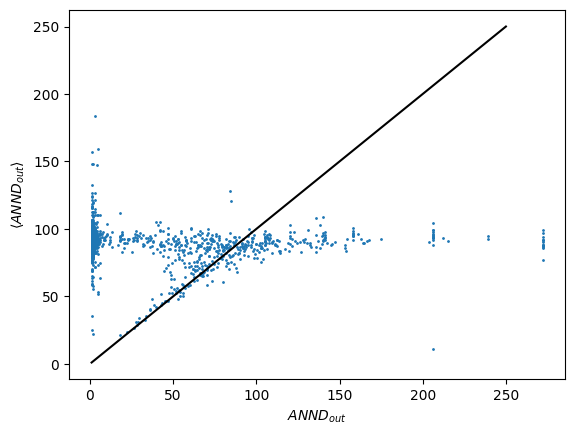

In [24]:
plt.plot([1,250], [1, 250], c="black")
plt.scatter(original_annd_out, avg_ens_annd_out, s=1)
plt.xlabel(r"$ANND_{out}$")
plt.ylabel(r"$\langle ANND_{out}\rangle$")

In [25]:
avg_is_nodes = np.mean([graph.degree().count(0) for graph in ensemble])
print("Average number of isolated nodes in the ensemble is", avg_is_nodes)

Average number of isolated nodes in the ensemble is 288.91


In [26]:
ensemble[0].degree().count(0)

299